# Analysis of QHD_G75 Covalent on nCov 

A demo of MDAnalysis tool on Molecular Dynamics simulation of the interaction of nCov protease and the G75 ligand.

[Files downloaded](https://figshare.com/articles/Molecular_dynamics_simulations_of_coronavirus_2019-nCoV_protease_model_in_complex_with_G75_and_G82_ligands_covalently_bound_/11788794) 
  
  
**Simulation info**:
* 500ps frame window
* 310K temperature

**Tools used**:
* [MDAnalysis](https://www.mdanalysis.org/)
* [MDtraj](http://mdtraj.org/latest/index.html)
* [GROMACS](http://www.gromacs.org/)
* [VDM](https://www.ks.uiuc.edu/Research/vmd/)

## Importing and reading the files

In [8]:
import MDAnalysis
import mdtraj as md_traj

import numpy as np
import matplotlib.pyplot as plt

# Create the universe of atoms

u = MDAnalysis.Universe('../datasets/QHD_G75_covalent/QHD_G75_covalent.gro', # topology
                        '../datasets/QHD_G75_covalent/QHD_G75_covalent.xtc') # trajectory

t = md_traj.load('../datasets/QHD_G75_covalent/QHD_G75_covalent.xtc', 
            top='../datasets/QHD_G75_covalent/QHD_G75_covalent.gro')

print("MD Analysis check:")
print(u)
# print(list(u.atoms[-3:]))

print("MD Traj check:")
print(t)

<Universe with 4752 atoms>
[<Atom 4750: C84 of type C of resname G75, resid 307 and segid SYSTEM>, <Atom 4751: O86 of type O of resname G75, resid 307 and segid SYSTEM>, <Atom 4752: O88 of type O of resname G75, resid 307 and segid SYSTEM>]
<mdtraj.Trajectory with 50004 frames, 4752 atoms, 307 residues, and unitcells>


## Extracting basic info

Basic info from the topology file.

In [9]:
uni_atom_group = u.atoms

print(f'Coordinates shape: {uni_atom_group.positions.shape}')  # Coordinates of each atom on the starting position
print(f'Center of mass: {uni_atom_group.center_of_mass()}') # Center of mass on the 3 axes
print(f'Total mass: {uni_atom_group.total_mass()}') # Total mass of atoms

Coordinates shape: (4752, 3)
Center of mass: [78.4322688  75.00627472 36.69610656]
Total mass: 34300.277


## Progression of the basic info

Having only the starting position does not help us make any useful conclusions. Now we will extract info from observing the progression of the above attributes through the trajectory frames.

A list of **covered features**:
* Radius of Gyration
* Solvent-Accesible Surface Area (SASA)

### Radius of Gyration

Radius of gyration is an indicator of protein structure compactness. It is concerned with how regular secondary structures are compactly packed in to 3D structure of protein. α proteins have the highest radius of gyration throughout the protein size range considered, suggesting a less tight packing as compared with β-and (α + β)-proteins. The lowest radius of gyration and, accordingly, the tightest packing are a characteristic of α/β-proteins. (https://www.researchgate.net/publication/226987521_Radius_of_gyration_as_an_indicator_of_protein_structure_compactness)
If a protein is stably folded, it will likely maintain a relatively steady value of Rg. If a protein unfolds, its Rg will change over time. (https://journals.plos.org/plosone/article/file?id=10.1371/journal.pone.0112456&type=printable)

\begin{equation*}
Rg^2 = \sum_{i=1}^N m_i\left( r_i - R_c \right)^2 
\end{equation*}

where $R_c$ the center of mass (excluding hydrogens), $r_i$ the coordinates of the i_th atom, $m_i$ the mass of the ith atom.

**GROMACS command**: `gmx gyrate -s topology.tpr -f trajectory.xtc -o outputfile.xvg`

**Python tool used:**: MDAnalysis

**Calculation time**" < 1 minute


        
 

Total frames: 50004


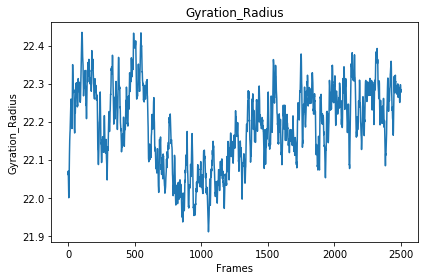

In [5]:
print(f'Total frames: {len(u.trajectory)}')

frame_indexes = np.arange(len(u.trajectory[::20]))

basic_info_dict = {
    "Gyration_Radius":[],
}

for ts in u.trajectory[::20]:
    basic_info_dict["Gyration_Radius"].append(u.atoms.radius_of_gyration())



for which_key, count in zip(basic_info_dict.keys(), range(len(basic_info_dict))):
    plt.subplot(1, 1, count + 1)
    plt.plot(frame_indexes, basic_info_dict[which_key], label=which_key)
    plt.xlabel("Frames")
    plt.ylabel(which_key)
    plt.title(which_key)

plt.tight_layout()
plt.show()

### Solvent-Accesible Surface Area (SASA)

The accessible surface area (ASA) or solvent-accessible surface area (SASA) is the surface area of a biomolecule that is accessible to a solvent [Ref](http://compbio.biosci.uq.edu.au/mediawiki/upload/d/d5/Lee1971_JMolBiol55-379.pdf). Measurement of ASA is usually described in units of square Ångstroms (a standard unit of measurement in molecular biology). ASA is typically calculated using the 'rolling ball' algorithm developed by Shrake & Rupley in 1973. This algorithm uses a sphere (of solvent) of a particular radius to 'probe' the surface of the molecule. [Ref](https://www.sciencedirect.com/science/article/abs/pii/0022283673900119?via%3Dihub)


Changes of the SASA indicate a change in the conformation of the protein and unfolding.

**GROMACS command**: `gmx sasa -f trajectory.xtc -s topology.tpr -o sasa.xvg`

**Python tool used**: None

**Calculation time**: ~= 30 minutes

<img src="https://drive.google.com/uc?export=view&id=17CHp_-xbBPDuRM13SmvmCMpc4Y1i2jwS" alt="drawing" width="200"/>

UFuncTypeError: ufunc 'multiply' did not contain a loop with signature matching types (dtype('<U32'), dtype('<U32')) -> dtype('<U32')

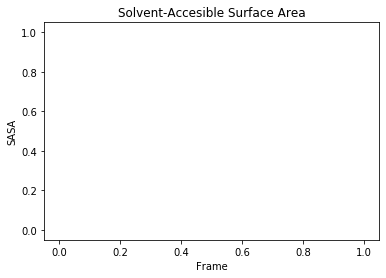

In [44]:
# Read the sasa file and plot it over the frames

import re

sasa_list = []
p = re.compile('\s+([0-9\.]*)\s+([0-9\.]*)\\n')

with open("../datasets/QHD_G75_covalent/sasa.xvg") as fp:
    Lines = fp.readlines() 
    for line in Lines:
        if(line[0] != '#' and line[0] != '@'):
            m = p.match(line)
#             print(m.group(1))
            sasa_list.append([m.group(1), m.group(2)])

sasa_list_arr = np.array(sasa_list).T # Cast to numpy array and transpose to have x, y axis values

plt.plot()
plt.title("Solvent-Accesible Surface Area")    
plt.xlabel('Frame')
plt.ylabel('SASA')
plt.plot(np.arange(len(u.trajectory[::100])),np.around(sasa_list_arr[1][::100], decimals=1), c='r', label='SASA')
leg = ax1.legend()
plt.tight_layout()

plt.show() 
